In [1]:
%matplotlib inline
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt

In [2]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])


In [4]:
class Memory:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6
    beta = 0.4
    beta_increment_per_sampling = 0.001

    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.capacity = capacity

    def _get_priority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._get_priority(error)
        self.tree.add(p, sample)

    def sample(self, n):
        batch = []
        idxs = []
        segment = self.tree.total() / n
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)


In [5]:
# Hyper Parameters
BATCH_SIZE = 32
LR = 1e-2                  # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 2000

In [6]:
env = gym.make('CartPole-v0')
env.seed(seed);

In [7]:
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [8]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        nn.init.xavier_uniform_(self.out.weight)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [9]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.pmemory = Memory(MEMORY_CAPACITY)
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss(reduce=False)

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

#     def store_transition(self, s, a, r, s_):
#         transition = np.hstack((s, [a, r], s_))
#         # replace the old memory with new memory
#         index = self.memory_counter % MEMORY_CAPACITY
#         self.memory[index, :] = transition
#         self.memory_counter += 1

    def store_transition(self, s, a, r, s_, done):
        
        ns = torch.unsqueeze(torch.FloatTensor(s_), 0)
        ns_vals = self.eval_net.forward(ns).data
        
        ps = torch.unsqueeze(torch.FloatTensor(s), 0)
        ps_vals = self.eval_net.forward(ps).data
        expected_q = ps_vals[0][a]

        if done:
            actual_q = r
        else:
            actual_q = r + GAMMA * torch.max(ns_vals)
        
        error = np.abs(expected_q - actual_q)
        self.pmemory.add(error, (s, a, r, s_, done))


#         transition = np.hstack((s, [a, r], s_))
#         # replace the old memory with new memory
#         index = self.memory_counter % MEMORY_CAPACITY
#         self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        #sample from pmemory
        mini_batch, idxs, is_weights = self.pmemory.sample(BATCH_SIZE)
        mini_batch = np.array(mini_batch).transpose()
        
        states = np.vstack(mini_batch[0])
        actions = np.vstack(mini_batch[1])
        rewards = np.vstack(mini_batch[2])
        next_states = np.vstack(mini_batch[3])
        dones = mini_batch[4]
        my_memory = np.hstack((states,actions,rewards,next_states))
        
        
        # sample batch transitions
#         sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
#         b_memory = self.memory[sample_index, :]
        
        b_memory = my_memory
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

         # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        
        errors = torch.abs(q_eval - q_target).data.numpy()
        # update priority
        for i in range(BATCH_SIZE):
            idx = idxs[i]
            self.pmemory.update(idx, errors[i])

        self.optimizer.zero_grad()
        
#         loss = self.loss_func(q_eval, q_target)
        loss = self.loss_func(q_eval, q_target)*torch.from_numpy(is_weights).float()
        
        self.optimizer.zero_grad()
        loss.mean().backward()
#         loss.backward()
        self.optimizer.step()

In [10]:
dqn = DQN()
NO_OF_EPISODES = 1000

In [11]:
print('\nCollecting experience...')
time_rec = []
flag = True
learn_start = 0
TIMESTEP_LIMIT = 200

for i_episode in range(NO_OF_EPISODES):
    s = env.reset()
    time_steps = 0
    while True:
#         env.render()
        time_steps += 1
        a = dqn.choose_action(s)

        # take action
        s_, r, done, info = env.step(a)
        
        if done:
            r = -1
            if time_steps >= TIMESTEP_LIMIT:
                r = 1
            
        dqn.store_transition(s, a, r, s_, done)
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
            if flag:
                print("Learning starts from EPISODE: ",i_episode)
                flag = False

        if done:
            print("EPISODE#{:4d} | TIME_STEPS: {:6d} | MEMORY_LENGTH: {:10d}".format(int(i_episode), int(time_steps), int(dqn.pmemory.tree.n_entries)))
            time_rec = np.append(time_rec, time_steps)
         
            break
        s = s_


EPISODE#   0 | TIME_STEPS:     10 | MEMORY_LENGTH:         10
EPISODE#   1 | TIME_STEPS:     10 | MEMORY_LENGTH:         20
EPISODE#   2 | TIME_STEPS:      9 | MEMORY_LENGTH:         29
EPISODE#   3 | TIME_STEPS:      8 | MEMORY_LENGTH:         37
EPISODE#   4 | TIME_STEPS:     14 | MEMORY_LENGTH:         51
EPISODE#   5 | TIME_STEPS:     10 | MEMORY_LENGTH:         61
EPISODE#   6 | TIME_STEPS:     10 | MEMORY_LENGTH:         71
EPISODE#   7 | TIME_STEPS:      9 | MEMORY_LENGTH:         80
EPISODE#   8 | TIME_STEPS:     10 | MEMORY_LENGTH:         90
EPISODE#   9 | TIME_STEPS:     13 | MEMORY_LENGTH:        103
EPISODE#  10 | TIME_STEPS:     10 | MEMORY_LENGTH:        113
EPISODE#  11 | TIME_STEPS:     11 | MEMORY_LENGTH:        124
EPISODE#  12 | TIME_STEPS:      9 | MEMORY_LENGTH:        133
EPISODE#  13 | TIME_STEPS:     10 | MEMORY_LENGTH:        143
EPISODE#  14 | TIME_STEPS:     12 | MEMORY_LENGTH:        155
EPISODE#  15 | TIME_STEPS:     10 | MEMORY_LENGTH:        165
EPISODE

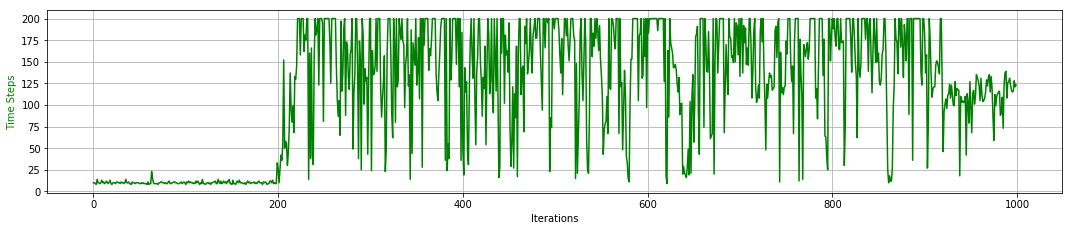

In [17]:
fig = plt.figure(figsize = (15,6))

ax2 = fig.add_subplot(2, 1, 1)
data = time_rec
ax2.plot(data, color = 'g')
# ax2.plot(np.ones_like(data)*200, 'r--')

ax2.set_xlabel('Iterations',color = 'k')
ax2.set_ylabel('Time Steps',color = 'g')
# ax2.set_ylim([1,2.5e2])
# ax2.set_yscale('log')

fig.tight_layout()
ax2.grid()
plt.show()

In [13]:
env.close()

In [14]:
# s = env.reset()
# while True:
#     env.render()
#     a = dqn.choose_greedy_action(s)
#     s_, r, done, info = env.step(a)
#     if done:
#         break
#     s = s_

In [15]:
# env.close()